In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,classification_report,roc_curve, auc
import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [79]:
#list_dir =glob.glob("/Users/Gaia_1/Desktop/tesi/Data after PP scores/*.txt")
list_dir =glob.glob("/Users/Gaia_1/Desktop/tesi/Data after PP 3mar/*.txt")

# List to hold individual DataFrames
dfs = []

# Iterate through each file in the directory
for file in list_dir:
    # Read the file into a DataFrame
    #file_path = os.path.join(directory, filename)
    df = pd.read_csv(file) #, delimiter='\t')  # Assuming tab-separated values
    dfs.append(df)

# Merge all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame as CSV
merged_df.to_csv("PPmodeled_data.csv", index=False)
dataset=merged_df
dataset


,Unnamed: 0,mu1,lam1,mu2,sigma2,mu3,sigma3,w1,w2,w3,score,Target,Stimulation
0,0,0.027703,0.024962,7.382214e-02,0.091277,0.387782,0.358340,1.000000,1.523384e-08,6.568792e-09,0.047622,0.0,0.0
1,0,0.027403,0.024679,7.312786e-02,0.095581,0.387636,0.360722,1.000000,6.584057e-09,2.506236e-09,0.050080,0.0,0.0
2,0,0.027337,0.024883,7.421555e-02,0.097155,0.387801,0.359421,1.000000,1.467632e-08,5.321754e-09,0.045987,0.0,0.0
3,0,0.027381,0.024853,7.586576e-02,0.103750,0.388068,0.358218,1.000000,5.672700e-08,1.962487e-08,0.047996,0.0,0.0
4,0,0.037986,0.025043,5.577287e-02,0.039695,0.359267,0.337021,0.721412,2.785877e-01,5.652347e-09,0.047503,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,0,0.046904,0.026115,5.371843e-02,0.057496,0.337064,0.255620,0.654208,3.457921e-01,1.357277e-08,0.080860,0.0,0.0
1003,0,0.046511,0.027237,5.062685e-02,0.055906,0.341286,0.285245,0.623621,3.763792e-01,6.464418e-09,0.090975,0.0,0.0
1004,0,0.049092,0.028202,2.657684e-02,0.078396,0.330979,0.246550,0.535016,4.649838e-01,8.578750e-09,0.179564,0.0,0.0
1005,0,0.047822,0.025732,4.338868e-02,0.067849,0.339346,0.246203,0.582075,4.179250e-01,5.385411e-08,0.122065,0.0,0.0


In [ ]:
dataset = pd.read_csv('PPmodeled_data.csv')

### Only baseline

dataset = dataset[dataset['Stimulation'] != 1]
dataset

### Dropping stimulation column

In [6]:
dataset=dataset.drop(['Stimulation'],axis=1)
dataset=dataset.drop(['score'],axis=1)
dataset = dataset.drop(['Unnamed: 0'],axis=1)

In [7]:
dataset['Target'].value_counts()

1.0    543
0.0    464
Name: Target, dtype: int64

In [8]:
dataset['Target'].value_counts(1)

1.0    0.539225
0.0    0.460775
Name: Target, dtype: float64

In [9]:
X = dataset.drop(['Target'],axis=1)
y= dataset['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Standardization

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# CV

In [10]:
cv = StratifiedKFold(4)

# PCA

pca = PCA(n_components=7,svd_solver='full')
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.fit(X_train).explained_variance_ratio_)
#print(cum_sum((pca.fit(X_train).explained_variance_ratio_)))

# Classification Tree

In [11]:
params = {'max_depth':np.linspace(2,10,dtype='int'),'criterion':['gini','entropy']}

clf = DecisionTreeClassifier(random_state=12)

gs_ct = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_ct=gs_ct.fit(X_train,y_train)
y_true, y_pred = y_test, gs_ct.predict(X_test)
#gs_pca = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)
#gs_pca = gs_pca.fit(X_train_pca,y_train)

## CT metrics

In [12]:
print("Best parameters set found :",gs_ct.best_params_,'\n')
print("Classification report on Test set\n")

roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

'''print('\n\n Result with PCA\n')
print("Best parameters set found :",gs_pca.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_pca.predict(X_test_pca)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)
'''

Best parameters set found : {'criterion': 'gini', 'max_depth': 4} 

Classification report on Test set

ROC AUC:  0.978
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       140
         1.0       0.99      0.97      0.98       163

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



'print(\'\n\n Result with PCA\n\')\nprint("Best parameters set found :",gs_pca.best_params_,\'\n\')\nprint("Classification report on Test set\n")\n\ny_true, y_pred = y_test, gs_pca.predict(X_test_pca)\n\naccuracy = round(accuracy_score(y_true, y_pred),3)\nrecall = round(recall_score(y_true, y_pred),3)\nprecision = round(precision_score(y_true, y_pred),3)\nroc_auc = round(roc_auc_score(y_true, y_pred),3)\n\nprint(\'Accuracy: \',accuracy)\nprint(\'Recall: \',recall)\nprint(\'Precision: \',precision)\nprint(\'ROC AUC: \',roc_auc)\n'

In [13]:
accuracy_ct = round(accuracy_score(y_true, y_pred),3)
recall_ct = round(recall_score(y_true, y_pred),3)
precision_ct = round(precision_score(y_true, y_pred),3)
roc_auc_ct = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_ct)
print('Recall: ',recall_ct)
print('Precision: ',precision_ct)
print('ROC AUC: ',roc_auc_ct)

Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.978


## CT matrix

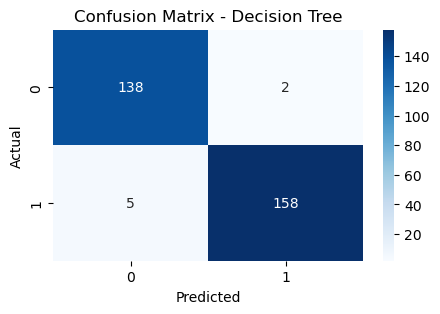

In [14]:
# Assuming clf is your trained DecisionTreeClassifier
y_pred = gs_ct.predict(X_test)  # Use gs instead of clf if you want to use the grid search optimized model

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


## CT feature info

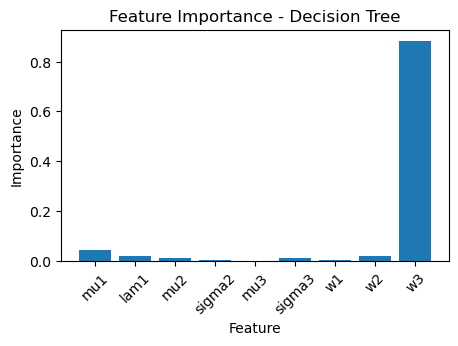

In [15]:
# Assuming X_train is your feature matrix and y_train is your target
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(5, 3))
plt.bar(X.columns, tree.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Decision Tree')
plt.xticks(rotation=45)
plt.show()


## ROC Curve

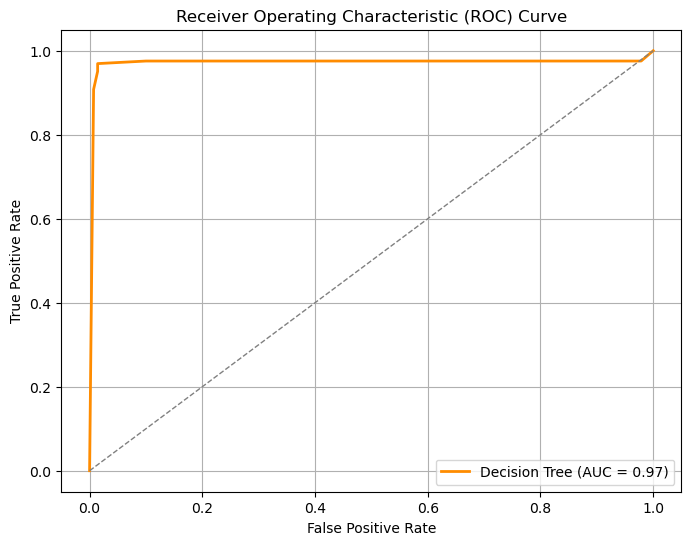

In [16]:
y_score_ct = gs_ct.predict_proba(X_test)[:,1]
fpr_ct, tpr_ct, _ = roc_curve(y_test, y_score_ct)
roc_auc_ct = auc(fpr_ct, tpr_ct)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_ct:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest

In [43]:
params = {'n_estimators':np.linspace(10,150,dtype='int',num=10),'max_depth':np.linspace(2,5,dtype='int'),'criterion':['gini','entropy']}

clf = RandomForestClassifier(n_jobs=-1,random_state=12)

gs_rf = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)

gs_rf=gs_rf.fit(X_train,y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
[CV 1/4; 1/1000] START criterion=gini, max_depth=2, n_estimators=10.............
[CV 1/4; 1/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.992 total time=   0.1s
[CV 1/4; 2/1000] START criterion=gini, max_depth=2, n_estimators=25.............
[CV 1/4; 2/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.994 total time=   0.1s
[CV 2/4; 3/1000] START criterion=gini, max_depth=2, n_estimators=41.............
[CV 2/4; 3/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.995 total time=   0.2s
[CV 2/4; 4/1000] START criterion=gini, max_depth=2, n_estimators=56.............
[CV 2/4; 4/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.995 total time=   0.2s
[CV 2/4; 5/1000] START criterion=gini, max_depth=2, n_estimators=72.............
[CV 2/4; 5/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.995 total time=   0.3s
[CV 1/4; 6/1000] START criterion=gi

[CV 2/4; 1/1000] START criterion=gini, max_depth=2, n_estimators=10.............
[CV 2/4; 1/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.995 total time=   0.1s
[CV 2/4; 2/1000] START criterion=gini, max_depth=2, n_estimators=25.............
[CV 2/4; 2/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.995 total time=   0.1s
[CV 3/4; 3/1000] START criterion=gini, max_depth=2, n_estimators=41.............
[CV 3/4; 3/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.988 total time=   0.2s
[CV 3/4; 4/1000] START criterion=gini, max_depth=2, n_estimators=56.............
[CV 3/4; 4/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.988 total time=   0.2s
[CV 1/4; 5/1000] START criterion=gini, max_depth=2, n_estimators=72.............
[CV 1/4; 5/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.993 total time=   0.3s
[CV 2/4; 6/1000] START criterion=gini, max_depth=2, n_estimators=87.............
[CV 2/4; 6/1000] EN

[CV 4/4; 1/1000] START criterion=gini, max_depth=2, n_estimators=10.............
[CV 4/4; 1/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.998 total time=   0.1s
[CV 3/4; 2/1000] START criterion=gini, max_depth=2, n_estimators=25.............
[CV 3/4; 2/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.989 total time=   0.1s
[CV 1/4; 3/1000] START criterion=gini, max_depth=2, n_estimators=41.............
[CV 1/4; 3/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.994 total time=   0.2s
[CV 1/4; 4/1000] START criterion=gini, max_depth=2, n_estimators=56.............
[CV 1/4; 4/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.993 total time=   0.3s
[CV 3/4; 5/1000] START criterion=gini, max_depth=2, n_estimators=72.............
[CV 3/4; 5/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.991 total time=   0.3s
[CV 3/4; 6/1000] START criterion=gini, max_depth=2, n_estimators=87.............
[CV 3/4; 6/1000] EN

[CV 3/4; 1/1000] START criterion=gini, max_depth=2, n_estimators=10.............
[CV 3/4; 1/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.988 total time=   0.1s
[CV 4/4; 2/1000] START criterion=gini, max_depth=2, n_estimators=25.............
[CV 4/4; 2/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.997 total time=   0.1s
[CV 4/4; 3/1000] START criterion=gini, max_depth=2, n_estimators=41.............
[CV 4/4; 3/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.998 total time=   0.2s
[CV 4/4; 4/1000] START criterion=gini, max_depth=2, n_estimators=56.............
[CV 4/4; 4/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.998 total time=   0.4s
[CV 4/4; 5/1000] START criterion=gini, max_depth=2, n_estimators=72.............
[CV 4/4; 5/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.998 total time=   0.4s
[CV 4/4; 6/1000] START criterion=gini, max_depth=2, n_estimators=87.............
[CV 4/4; 6/1000] EN

[CV 1/4; 88/1000] START criterion=gini, max_depth=2, n_estimators=118...........
[CV 1/4; 88/1000] END criterion=gini, max_depth=2, n_estimators=118;, score=0.992 total time=   0.6s
[CV 2/4; 89/1000] START criterion=gini, max_depth=2, n_estimators=134...........
[CV 2/4; 89/1000] END criterion=gini, max_depth=2, n_estimators=134;, score=0.995 total time=   0.6s
[CV 2/4; 90/1000] START criterion=gini, max_depth=2, n_estimators=150...........
[CV 2/4; 90/1000] END criterion=gini, max_depth=2, n_estimators=150;, score=0.995 total time=   0.6s
[CV 1/4; 91/1000] START criterion=gini, max_depth=2, n_estimators=10............
[CV 1/4; 91/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.992 total time=   0.1s
[CV 3/4; 91/1000] START criterion=gini, max_depth=2, n_estimators=10............
[CV 3/4; 91/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.988 total time=   0.1s
[CV 2/4; 92/1000] START criterion=gini, max_depth=2, n_estimators=25............
[CV 2/4; 92

[CV 4/4; 91/1000] START criterion=gini, max_depth=2, n_estimators=10............
[CV 4/4; 91/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.998 total time=   0.1s
[CV 3/4; 92/1000] START criterion=gini, max_depth=2, n_estimators=25............
[CV 3/4; 92/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.989 total time=   0.1s
[CV 2/4; 93/1000] START criterion=gini, max_depth=2, n_estimators=41............
[CV 2/4; 93/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.995 total time=   0.3s
[CV 1/4; 94/1000] START criterion=gini, max_depth=2, n_estimators=56............
[CV 1/4; 94/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.993 total time=   0.3s
[CV 1/4; 95/1000] START criterion=gini, max_depth=2, n_estimators=72............
[CV 1/4; 95/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.993 total time=   0.4s
[CV 1/4; 96/1000] START criterion=gini, max_depth=2, n_estimators=87............
[CV 1/4; 96/10

[CV 2/4; 96/1000] START criterion=gini, max_depth=2, n_estimators=87............
[CV 2/4; 96/1000] END criterion=gini, max_depth=2, n_estimators=87;, score=0.995 total time=   0.4s
[CV 2/4; 97/1000] START criterion=gini, max_depth=2, n_estimators=103...........
[CV 2/4; 97/1000] END criterion=gini, max_depth=2, n_estimators=103;, score=0.996 total time=   0.5s
[CV 1/4; 98/1000] START criterion=gini, max_depth=2, n_estimators=118...........
[CV 1/4; 98/1000] END criterion=gini, max_depth=2, n_estimators=118;, score=0.992 total time=   0.6s
[CV 2/4; 99/1000] START criterion=gini, max_depth=2, n_estimators=134...........
[CV 2/4; 99/1000] END criterion=gini, max_depth=2, n_estimators=134;, score=0.995 total time=   0.6s
[CV 2/4; 100/1000] START criterion=gini, max_depth=2, n_estimators=150..........
[CV 2/4; 100/1000] END criterion=gini, max_depth=2, n_estimators=150;, score=0.995 total time=   0.7s
[CV 3/4; 101/1000] START criterion=gini, max_depth=2, n_estimators=10...........
[CV 3/4; 

[CV 4/4; 179/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 4/4; 179/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.998 total time=   0.6s
[CV 4/4; 180/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 4/4; 180/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.998 total time=   0.6s
[CV 1/4; 181/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 1/4; 181/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.994 total time=   0.1s
[CV 1/4; 182/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 1/4; 182/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.994 total time=   0.1s
[CV 1/4; 183/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 1/4; 183/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.994 total time=   0.2s
[CV 1/4; 184/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 1/4

[CV 3/4; 174/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 3/4; 174/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.991 total time=   0.3s
[CV 4/4; 175/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 4/4; 175/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=0.998 total time=   0.3s
[CV 3/4; 176/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 3/4; 176/1000] END criterion=gini, max_depth=3, n_estimators=87;, score=0.994 total time=   0.4s
[CV 2/4; 177/1000] START criterion=gini, max_depth=3, n_estimators=103..........
[CV 2/4; 177/1000] END criterion=gini, max_depth=3, n_estimators=103;, score=0.996 total time=   0.5s
[CV 1/4; 178/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 1/4; 178/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.993 total time=   0.5s
[CV 1/4; 179/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 1/4

[CV 3/4; 181/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 3/4; 181/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.984 total time=   0.1s
[CV 3/4; 182/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 3/4; 182/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.988 total time=   0.1s
[CV 2/4; 183/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 2/4; 183/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.995 total time=   0.3s
[CV 2/4; 184/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 2/4; 184/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.995 total time=   0.3s
[CV 3/4; 185/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 3/4; 185/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=0.992 total time=   0.4s
[CV 3/4; 186/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 3/4; 

[CV 2/4; 186/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 2/4; 186/1000] END criterion=gini, max_depth=3, n_estimators=87;, score=0.996 total time=   0.4s
[CV 2/4; 187/1000] START criterion=gini, max_depth=3, n_estimators=103..........
[CV 2/4; 187/1000] END criterion=gini, max_depth=3, n_estimators=103;, score=0.996 total time=   0.6s
[CV 3/4; 188/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 3/4; 188/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.993 total time=   0.6s
[CV 3/4; 189/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 3/4; 189/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.993 total time=   0.8s
[CV 3/4; 190/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 3/4; 190/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.994 total time=   0.8s
[CV 3/4; 193/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 3

[CV 4/4; 265/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 4/4; 265/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=0.998 total time=   0.4s
[CV 4/4; 266/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 4/4; 266/1000] END criterion=gini, max_depth=3, n_estimators=87;, score=0.998 total time=   0.5s
[CV 4/4; 267/1000] START criterion=gini, max_depth=3, n_estimators=103..........
[CV 4/4; 267/1000] END criterion=gini, max_depth=3, n_estimators=103;, score=0.998 total time=   0.5s
[CV 4/4; 268/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 4/4; 268/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.998 total time=   0.6s
[CV 4/4; 269/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 4/4; 269/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.998 total time=   0.6s
[CV 4/4; 270/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 4/

[CV 3/4; 268/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 3/4; 268/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.993 total time=   0.6s
[CV 3/4; 269/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 3/4; 269/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.993 total time=   0.5s
[CV 2/4; 270/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 2/4; 270/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.996 total time=   0.6s
[CV 2/4; 271/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 2/4; 271/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.995 total time=   0.1s
[CV 1/4; 272/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 1/4; 272/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.994 total time=   0.1s
[CV 4/4; 272/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 4/

[CV 2/4; 261/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 2/4; 261/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.995 total time=   0.1s
[CV 1/4; 262/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 1/4; 262/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.994 total time=   0.1s
[CV 4/4; 262/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 4/4; 262/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.999 total time=   0.1s
[CV 3/4; 263/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 3/4; 263/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.992 total time=   0.2s
[CV 2/4; 264/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 2/4; 264/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.995 total time=   0.3s
[CV 1/4; 265/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 1/4; 

[CV 2/4; 282/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 2/4; 282/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.996 total time=   0.2s
[CV 3/4; 283/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 3/4; 283/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.992 total time=   0.2s
[CV 3/4; 284/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 3/4; 284/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.991 total time=   0.3s
[CV 3/4; 285/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 3/4; 285/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=0.992 total time=   0.3s
[CV 2/4; 286/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 2/4; 286/1000] END criterion=gini, max_depth=3, n_estimators=87;, score=0.996 total time=   0.4s
[CV 1/4; 287/1000] START criterion=gini, max_depth=3, n_estimators=103..........
[CV 1/4; 

[CV 1/4; 353/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 1/4; 353/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=0.992 total time=   0.2s
[CV 4/4; 353/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 4/4; 353/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=0.998 total time=   0.2s
[CV 3/4; 354/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 3/4; 354/1000] END criterion=gini, max_depth=4, n_estimators=56;, score=0.993 total time=   0.3s
[CV 3/4; 355/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 3/4; 355/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=0.995 total time=   0.3s
[CV 3/4; 356/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 3/4; 356/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.996 total time=   0.4s
[CV 2/4; 357/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 2/4; 

[CV 3/4; 353/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 3/4; 353/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=0.994 total time=   0.2s
[CV 2/4; 354/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 2/4; 354/1000] END criterion=gini, max_depth=4, n_estimators=56;, score=0.996 total time=   0.3s
[CV 2/4; 355/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 2/4; 355/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=0.997 total time=   0.3s
[CV 2/4; 356/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 2/4; 356/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.997 total time=   0.4s
[CV 1/4; 357/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 1/4; 357/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.993 total time=   0.5s
[CV 2/4; 358/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 2/4;

[CV 1/4; 348/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 1/4; 348/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.993 total time=   0.5s
[CV 4/4; 348/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 4/4; 348/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.998 total time=   0.5s
[CV 4/4; 349/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 4/4; 349/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.998 total time=   0.7s
[CV 4/4; 350/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 4/4; 350/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=0.999 total time=   0.9s
[CV 4/4; 354/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 4/4; 354/1000] END criterion=gini, max_depth=4, n_estimators=56;, score=0.998 total time=   0.3s
[CV 4/4; 355/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 4

[CV 3/4; 378/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 3/4; 378/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.995 total time=   0.5s
[CV 4/4; 379/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 4/4; 379/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.998 total time=   0.6s
[CV 3/4; 380/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 3/4; 380/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=0.996 total time=   0.7s
[CV 3/4; 381/1000] START criterion=gini, max_depth=4, n_estimators=10...........
[CV 3/4; 381/1000] END criterion=gini, max_depth=4, n_estimators=10;, score=0.986 total time=   0.1s
[CV 3/4; 382/1000] START criterion=gini, max_depth=4, n_estimators=25...........
[CV 3/4; 382/1000] END criterion=gini, max_depth=4, n_estimators=25;, score=0.993 total time=   0.2s
[CV 4/4; 383/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 4/

[CV 1/4; 435/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 1/4; 435/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=0.992 total time=   0.4s
[CV 4/4; 436/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 4/4; 436/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.998 total time=   0.4s
[CV 4/4; 437/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 4/4; 437/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.998 total time=   0.6s
[CV 4/4; 438/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 4/4; 438/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.998 total time=   0.6s
[CV 4/4; 439/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 4/4; 439/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.998 total time=   0.6s
[CV 3/4; 440/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 3/

[CV 3/4; 519/1000] END criterion=entropy, max_depth=2, n_estimators=134;, score=0.993 total time=   0.5s[CV 4/4; 446/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 4/4; 446/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.998 total time=   0.6s
[CV 4/4; 447/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 4/4; 447/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.998 total time=   0.6s
[CV 4/4; 448/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 4/4; 448/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.998 total time=   0.7s
[CV 4/4; 449/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 4/4; 449/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.998 total time=   0.7s
[CV 4/4; 450/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 4/4; 450/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=0.999 t

[CV 4/4; 435/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 4/4; 435/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=0.998 total time=   0.3s
[CV 3/4; 436/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 3/4; 436/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.996 total time=   0.4s
[CV 1/4; 437/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 1/4; 437/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.993 total time=   0.5s
[CV 2/4; 438/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 2/4; 438/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.997 total time=   0.6s
[CV 1/4; 439/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 1/4; 439/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.993 total time=   0.7s
[CV 4/4; 440/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 4/

[CV 4/4; 468/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 4/4; 468/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.998 total time=   0.6s
[CV 4/4; 469/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 4/4; 469/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.998 total time=   0.7s
[CV 4/4; 470/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 4/4; 470/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=0.999 total time=   0.8s
[CV 4/4; 472/1000] START criterion=gini, max_depth=4, n_estimators=25...........
[CV 4/4; 472/1000] END criterion=gini, max_depth=4, n_estimators=25;, score=0.998 total time=   0.1s
[CV 4/4; 473/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 4/4; 473/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=0.998 total time=   0.2s
[CV 4/4; 474/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 4/


[CV 1/4; 520/1000] START criterion=entropy, max_depth=2, n_estimators=150.......
[CV 1/4; 520/1000] END criterion=entropy, max_depth=2, n_estimators=150;, score=0.994 total time=   0.7s
[CV 1/4; 521/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 1/4; 521/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.993 total time=   0.1s
[CV 3/4; 521/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 3/4; 521/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.991 total time=   0.1s
[CV 1/4; 522/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 1/4; 522/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.994 total time=   0.2s
[CV 4/4; 522/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 4/4; 522/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.998 total time=   0.1s
[CV 3/4; 523/1000] START criterion=entropy, max_depth=2, n_estimators=41.

[CV 3/4; 534/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.991 total time=   0.2s
[CV 2/4; 535/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 2/4; 535/1000] END criterion=entropy, max_depth=2, n_estimators=72;, score=0.995 total time=   0.3s
[CV 2/4; 536/1000] START criterion=entropy, max_depth=2, n_estimators=87........
[CV 2/4; 536/1000] END criterion=entropy, max_depth=2, n_estimators=87;, score=0.995 total time=   0.4s
[CV 2/4; 537/1000] START criterion=entropy, max_depth=2, n_estimators=103.......
[CV 2/4; 537/1000] END criterion=entropy, max_depth=2, n_estimators=103;, score=0.995 total time=   0.5s
[CV 1/4; 538/1000] START criterion=entropy, max_depth=2, n_estimators=118.......
[CV 1/4; 538/1000] END criterion=entropy, max_depth=2, n_estimators=118;, score=0.994 total time=   0.6s
[CV 2/4; 539/1000] START criterion=entropy, max_depth=2, n_estimators=134.......
[CV 2/4; 539/1000] END criterion=entropy, max_depth=2, n_estimators=134;,

[CV 1/4; 529/1000] END criterion=entropy, max_depth=2, n_estimators=134;, score=0.994 total time=   0.5s
[CV 2/4; 530/1000] START criterion=entropy, max_depth=2, n_estimators=150.......
[CV 2/4; 530/1000] END criterion=entropy, max_depth=2, n_estimators=150;, score=0.995 total time=   0.6s
[CV 3/4; 531/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 3/4; 531/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.991 total time=   0.1s
[CV 2/4; 532/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 2/4; 532/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.995 total time=   0.2s
[CV 2/4; 533/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 2/4; 533/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.995 total time=   0.2s
[CV 2/4; 534/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 2/4; 534/1000] END criterion=entropy, max_depth=2, n_estimators=56;, 

[CV 2/4; 561/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.995 total time=   0.1s
[CV 3/4; 561/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 3/4; 561/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.991 total time=   0.1s
[CV 2/4; 562/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 2/4; 562/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.995 total time=   0.2s
[CV 2/4; 563/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 2/4; 563/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.995 total time=   0.2s
[CV 1/4; 564/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 1/4; 564/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.994 total time=   0.3s
[CV 1/4; 565/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 1/4; 565/1000] END criterion=entropy, max_depth=2, n_estimators=72;, sc

[CV 4/4; 601/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 4/4; 601/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.998 total time=   0.1s
[CV 2/4; 602/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 2/4; 602/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.995 total time=   0.1s
[CV 1/4; 603/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 1/4; 603/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.994 total time=   0.2s
[CV 4/4; 603/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 4/4; 603/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.998 total time=   0.2s
[CV 3/4; 604/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 3/4; 604/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.991 total time=   0.3s
[CV 2/4; 605/1000] START criterion=entropy, max_depth=2, n_estimators=72...

[CV 3/4; 621/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.991 total time=   0.1s
[CV 2/4; 622/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 2/4; 622/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.995 total time=   0.2s
[CV 1/4; 623/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 1/4; 623/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.994 total time=   0.3s
[CV 4/4; 623/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 4/4; 623/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.998 total time=   0.3s
[CV 4/4; 624/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 4/4; 624/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.998 total time=   0.3s
[CV 4/4; 625/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 4/4; 625/1000] END criterion=entropy, max_depth=2, n_estimators=72;, sc

[CV 3/4; 622/1000] END criterion=entropy, max_depth=2, n_estimators=25;, score=0.992 total time=   0.2s
[CV 2/4; 623/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 2/4; 623/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.995 total time=   0.2s
[CV 2/4; 624/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 2/4; 624/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.995 total time=   0.3s
[CV 2/4; 625/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 2/4; 625/1000] END criterion=entropy, max_depth=2, n_estimators=72;, score=0.995 total time=   0.4s
[CV 2/4; 626/1000] START criterion=entropy, max_depth=2, n_estimators=87........
[CV 2/4; 626/1000] END criterion=entropy, max_depth=2, n_estimators=87;, score=0.995 total time=   0.4s
[CV 2/4; 627/1000] START criterion=entropy, max_depth=2, n_estimators=103.......
[CV 2/4; 627/1000] END criterion=entropy, max_depth=2, n_estimators=103;, s

[CV 2/4; 653/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.995 total time=   0.2s
[CV 4/4; 653/1000] START criterion=entropy, max_depth=2, n_estimators=41........
[CV 4/4; 653/1000] END criterion=entropy, max_depth=2, n_estimators=41;, score=0.998 total time=   0.2s
[CV 3/4; 654/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 3/4; 654/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.991 total time=   0.3s
[CV 2/4; 655/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 2/4; 655/1000] END criterion=entropy, max_depth=2, n_estimators=72;, score=0.995 total time=   0.5s
[CV 3/4; 656/1000] START criterion=entropy, max_depth=2, n_estimators=87........
[CV 3/4; 656/1000] END criterion=entropy, max_depth=2, n_estimators=87;, score=0.992 total time=   0.4s
[CV 3/4; 657/1000] START criterion=entropy, max_depth=2, n_estimators=103.......
[CV 3/4; 657/1000] END criterion=entropy, max_depth=2, n_estimators=103;, s

[CV 2/4; 688/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 2/4; 688/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=0.996 total time=   0.6s
[CV 2/4; 689/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 2/4; 689/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=0.996 total time=   0.6s
[CV 1/4; 690/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 1/4; 690/1000] END criterion=entropy, max_depth=3, n_estimators=150;, score=0.993 total time=   0.8s
[CV 1/4; 691/1000] START criterion=entropy, max_depth=3, n_estimators=10........
[CV 1/4; 691/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.994 total time=   0.1s
[CV 3/4; 691/1000] START criterion=entropy, max_depth=3, n_estimators=10........
[CV 3/4; 691/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.991 total time=   0.1s
[CV 1/4; 692/1000] START criterion=entropy, max_depth=3, n_estimators=25

[CV 4/4; 711/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.999 total time=   0.1s
[CV 3/4; 712/1000] START criterion=entropy, max_depth=3, n_estimators=25........
[CV 3/4; 712/1000] END criterion=entropy, max_depth=3, n_estimators=25;, score=0.991 total time=   0.1s
[CV 3/4; 713/1000] START criterion=entropy, max_depth=3, n_estimators=41........
[CV 3/4; 713/1000] END criterion=entropy, max_depth=3, n_estimators=41;, score=0.992 total time=   0.2s
[CV 3/4; 714/1000] START criterion=entropy, max_depth=3, n_estimators=56........
[CV 3/4; 714/1000] END criterion=entropy, max_depth=3, n_estimators=56;, score=0.992 total time=   0.3s
[CV 3/4; 715/1000] START criterion=entropy, max_depth=3, n_estimators=72........
[CV 3/4; 715/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.992 total time=   0.3s
[CV 3/4; 716/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 3/4; 716/1000] END criterion=entropy, max_depth=3, n_estimators=87;, sc

[CV 3/4; 745/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.992 total time=   0.4s
[CV 4/4; 746/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 4/4; 746/1000] END criterion=entropy, max_depth=3, n_estimators=87;, score=0.999 total time=   0.4s
[CV 4/4; 747/1000] START criterion=entropy, max_depth=3, n_estimators=103.......
[CV 4/4; 747/1000] END criterion=entropy, max_depth=3, n_estimators=103;, score=0.999 total time=   0.5s
[CV 4/4; 748/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 4/4; 748/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=0.999 total time=   0.5s
[CV 2/4; 749/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 2/4; 749/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=0.996 total time=   0.6s
[CV 1/4; 750/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 1/4; 750/1000] END criterion=entropy, max_depth=3, n_estimators=150;

[CV 3/4; 780/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 3/4; 780/1000] END criterion=entropy, max_depth=3, n_estimators=150;, score=0.994 total time=   0.6s
[CV 1/4; 781/1000] START criterion=entropy, max_depth=3, n_estimators=10........
[CV 1/4; 781/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.994 total time=   0.1s
[CV 4/4; 781/1000] START criterion=entropy, max_depth=3, n_estimators=10........
[CV 4/4; 781/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.999 total time=   0.1s
[CV 3/4; 782/1000] START criterion=entropy, max_depth=3, n_estimators=25........
[CV 3/4; 782/1000] END criterion=entropy, max_depth=3, n_estimators=25;, score=0.991 total time=   0.1s
[CV 2/4; 783/1000] START criterion=entropy, max_depth=3, n_estimators=41........
[CV 2/4; 783/1000] END criterion=entropy, max_depth=3, n_estimators=41;, score=0.996 total time=   0.3s
[CV 1/4; 784/1000] START criterion=entropy, max_depth=3, n_estimators=56..

[CV 2/4; 795/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.995 total time=   0.3s
[CV 2/4; 796/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 2/4; 796/1000] END criterion=entropy, max_depth=3, n_estimators=87;, score=0.996 total time=   0.4s
[CV 2/4; 797/1000] START criterion=entropy, max_depth=3, n_estimators=103.......
[CV 2/4; 797/1000] END criterion=entropy, max_depth=3, n_estimators=103;, score=0.996 total time=   0.5s
[CV 1/4; 798/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 1/4; 798/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=0.993 total time=   0.5s
[CV 1/4; 799/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 1/4; 799/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=0.993 total time=   0.6s
[CV 1/4; 800/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 1/4; 800/1000] END criterion=entropy, max_depth=3, n_estimators=150;

[CV 3/4; 786/1000] END criterion=entropy, max_depth=3, n_estimators=87;, score=0.994 total time=   0.5s
[CV 3/4; 787/1000] START criterion=entropy, max_depth=3, n_estimators=103.......
[CV 3/4; 787/1000] END criterion=entropy, max_depth=3, n_estimators=103;, score=0.994 total time=   0.5s
[CV 3/4; 788/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 3/4; 788/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=0.994 total time=   0.6s
[CV 3/4; 789/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 3/4; 789/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=0.994 total time=   0.8s
[CV 3/4; 790/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 3/4; 790/1000] END criterion=entropy, max_depth=3, n_estimators=150;, score=0.994 total time=   0.8s
[CV 4/4; 792/1000] START criterion=entropy, max_depth=3, n_estimators=25........
[CV 4/4; 792/1000] END criterion=entropy, max_depth=3, n_estimators=25;

[CV 1/4; 838/1000] END criterion=entropy, max_depth=4, n_estimators=118;, score=0.993 total time=   0.6s
[CV 1/4; 839/1000] START criterion=entropy, max_depth=4, n_estimators=134.......
[CV 1/4; 839/1000] END criterion=entropy, max_depth=4, n_estimators=134;, score=0.992 total time=   0.7s
[CV 2/4; 840/1000] START criterion=entropy, max_depth=4, n_estimators=150.......
[CV 2/4; 840/1000] END criterion=entropy, max_depth=4, n_estimators=150;, score=0.997 total time=   0.7s
[CV 3/4; 841/1000] START criterion=entropy, max_depth=4, n_estimators=10........
[CV 3/4; 841/1000] END criterion=entropy, max_depth=4, n_estimators=10;, score=0.988 total time=   0.1s
[CV 2/4; 842/1000] START criterion=entropy, max_depth=4, n_estimators=25........
[CV 2/4; 842/1000] END criterion=entropy, max_depth=4, n_estimators=25;, score=0.996 total time=   0.1s
[CV 4/4; 842/1000] START criterion=entropy, max_depth=4, n_estimators=25........
[CV 4/4; 842/1000] END criterion=entropy, max_depth=4, n_estimators=25;,

[CV 4/4; 866/1000] START criterion=entropy, max_depth=4, n_estimators=87........
[CV 4/4; 866/1000] END criterion=entropy, max_depth=4, n_estimators=87;, score=0.999 total time=   0.4s
[CV 4/4; 867/1000] START criterion=entropy, max_depth=4, n_estimators=103.......
[CV 4/4; 867/1000] END criterion=entropy, max_depth=4, n_estimators=103;, score=0.999 total time=   0.5s
[CV 4/4; 868/1000] START criterion=entropy, max_depth=4, n_estimators=118.......
[CV 4/4; 868/1000] END criterion=entropy, max_depth=4, n_estimators=118;, score=0.999 total time=   0.6s
[CV 4/4; 869/1000] START criterion=entropy, max_depth=4, n_estimators=134.......
[CV 4/4; 869/1000] END criterion=entropy, max_depth=4, n_estimators=134;, score=0.999 total time=   0.7s
[CV 4/4; 870/1000] START criterion=entropy, max_depth=4, n_estimators=150.......
[CV 4/4; 870/1000] END criterion=entropy, max_depth=4, n_estimators=150;, score=0.999 total time=   1.0s
[CV 4/4; 873/1000] START criterion=entropy, max_depth=4, n_estimators=4

## RF metrics

In [44]:
print("Best parameters set found :",gs_rf.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_rf.predict(X_test)

roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Best parameters set found : {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 118} 

Classification report on Test set

ROC AUC:  0.978
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       140
         1.0       0.99      0.97      0.98       163

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



In [45]:
y_true, y_pred = y_test, gs_rf.predict(X_test)
accuracy_rf = round(accuracy_score(y_true, y_pred),3)
recall_rf = round(recall_score(y_true, y_pred),3)
precision_rf = round(precision_score(y_true, y_pred),3)
roc_auc_rf = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_rf)
print('Recall: ',recall_rf)
print('Precision: ',precision_rf)
print('ROC AUC: ',roc_auc_rf)

Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.978


## RF matrix

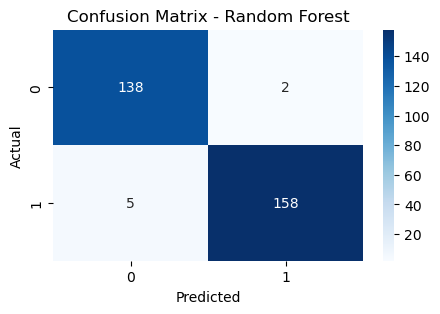

In [46]:
# Assuming clf is your trained RandomForestClassifier
#y_pred = gs_rf.predict(X_test)  # Use gs instead of clf if you want to use the grid search optimized model

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


## RF feature info

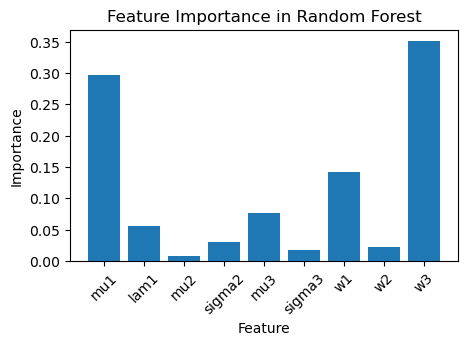

In [47]:
# Assuming X_train is your feature matrix and y_train is your target
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

feature_importances = forest.feature_importances_
feature_names = X.columns  # Assuming X is your DataFrame without the target column

plt.figure(figsize=(5, 3))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)
plt.show()


## ROC Curve

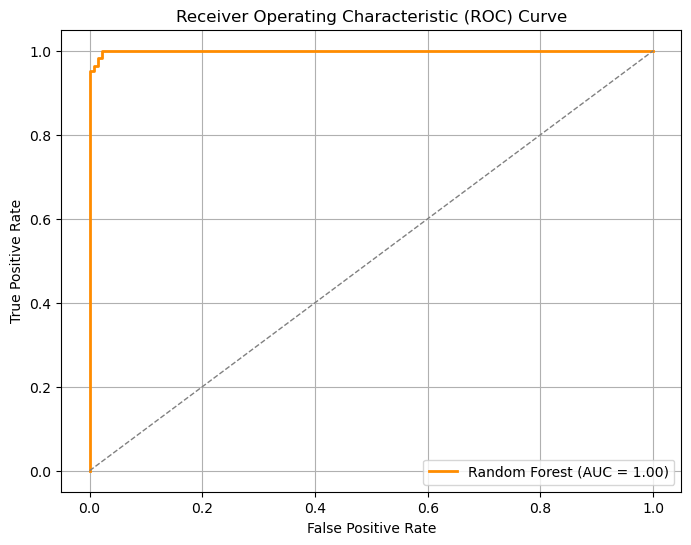

In [49]:
y_score_rf = gs_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Logistic Regression

In [80]:
params = {'C': np.logspace(-3, 3, 50), 'penalty': ['l1', 'l2']}

clf = LogisticRegression(solver='liblinear',random_state=24)

gs_logreg = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_logreg=gs_logreg.fit(X_train,y_train)
print("Best parameters set found :",gs_logreg.best_params_,'\n')

y_true, y_pred = y_test, gs_logreg.predict(X_test)

Best parameters set found : {'C': 323.745754281764, 'penalty': 'l1'} 



## LR metrics

In [81]:
roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ROC AUC:  0.974
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       140
         1.0       0.99      0.96      0.98       163

    accuracy                           0.97       303
   macro avg       0.97      0.97      0.97       303
weighted avg       0.97      0.97      0.97       303



In [82]:
y_true, y_pred = y_test, gs_logreg.predict(X_test)
accuracy_lr = round(accuracy_score(y_true, y_pred),3)
recall_lr = round(recall_score(y_true, y_pred),3)
precision_lr = round(precision_score(y_true, y_pred),3)
roc_auc_lr = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_lr)
print('Recall: ',recall_lr)
print('Precision: ',precision_lr)
print('ROC AUC: ',roc_auc_lr)

Accuracy:  0.974
Recall:  0.963
Precision:  0.987
ROC AUC:  0.974


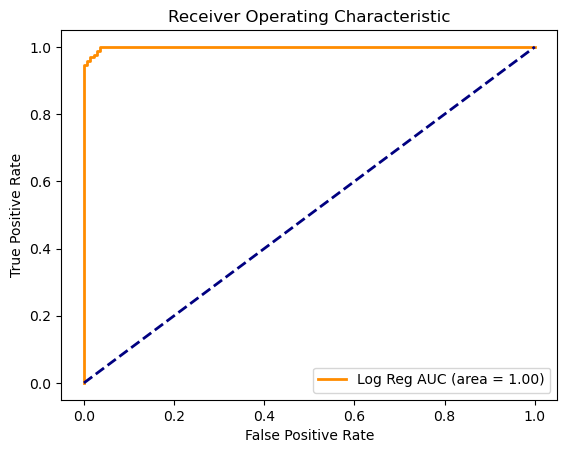

In [83]:
y_prob = gs_logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Log Reg AUC (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## LR matrix

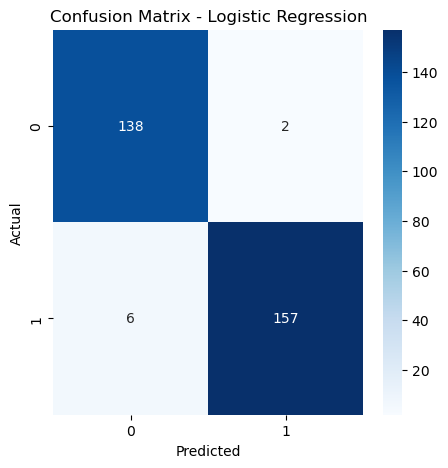

In [84]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


## LR feature info

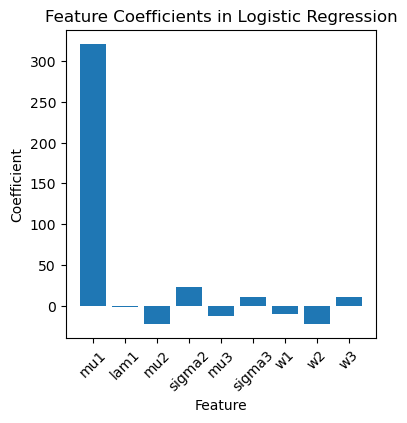

In [85]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Assuming log_reg is your trained Logistic Regression model
coefficients = gs_logreg.best_estimator_.coef_[0]  # Use gs.best_estimator_ to get the best model from grid search
feature_names = X.columns  # Assuming X is your DataFrame without the target column

plt.figure(figsize=(4, 4))
plt.bar(feature_names, coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Logistic Regression')
plt.xticks(rotation=45)
plt.show()


# SVM

In [62]:
# Define parameters for grid search
params = {'C': np.logspace(-3, 3, 50), 'kernel': ['linear'], 'probability': [True]}

# Define SVM classifier
clf = SVC(random_state=12)

# Create grid search object
gs_svm = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs=-1)

# Perform grid search
gs_svm = gs_svm.fit(X_train, y_train)

# Print best parameters found
print("Best parameters set found:", gs_svm.best_params_, '\n')

# Make predictions on the test set
y_true, y_pred = y_test, gs_svm.predict(X_test)

Best parameters set found: {'C': 568.9866029018293, 'kernel': 'linear', 'probability': True} 



In [63]:
roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ROC AUC:  0.981
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       140
         1.0       0.99      0.97      0.98       163

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



In [59]:
y_true, y_pred = y_test, gs_svm.predict(X_test)
accuracy_svm = round(accuracy_score(y_true, y_pred),3)
recall_svm = round(recall_score(y_true, y_pred),3)
precision_svm = round(precision_score(y_true, y_pred),3)
roc_auc_svm = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_svm)
print('Recall: ',recall_svm)
print('Precision: ',precision_svm)
print('ROC AUC: ',roc_auc_svm)

Accuracy:  0.99
Recall:  0.988
Precision:  0.994
ROC AUC:  0.99


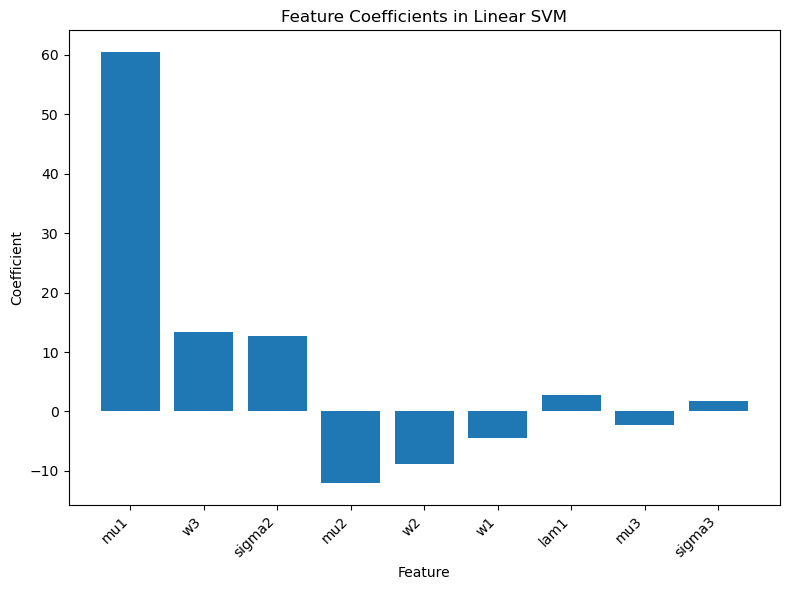

In [93]:
import numpy as np

# Get the coefficients of the SVM model
coefficients = gs_svm.best_estimator_.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Combine coefficients and feature names
feature_coefficients = list(zip(feature_names, coefficients))

# Sort feature coefficients based on absolute coefficient values
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Unzip sorted features and coefficients
sorted_features, sorted_coefficients = zip(*sorted_feature_coefficients)

# Plot feature coefficients
plt.figure(figsize=(8, 6))
plt.bar(sorted_features, sorted_coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Linear SVM')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feat_imp_SVM.jpg')
plt.show()


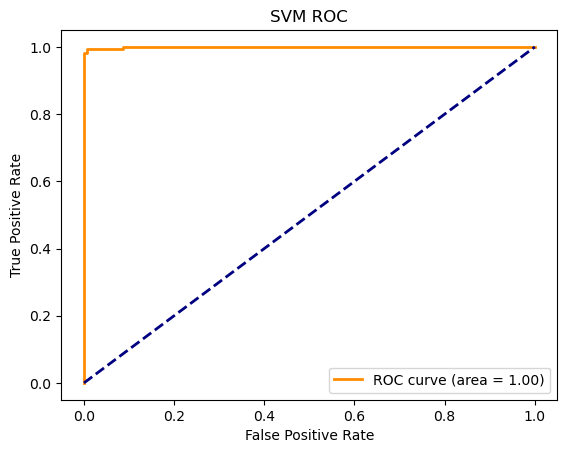

In [60]:
y_prob = gs_svm.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.show()

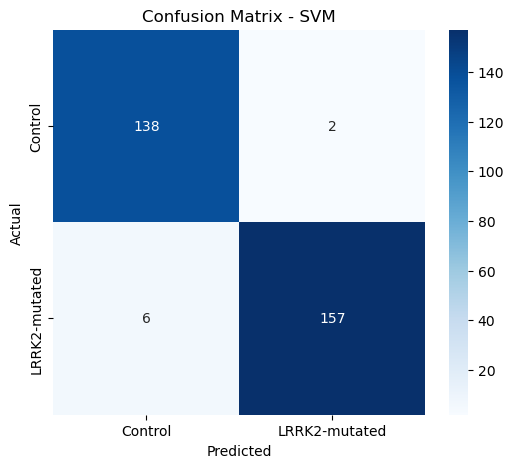

In [96]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Control', 'LRRK2-mutated']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.savefig('conf_mat_SVM.jpg')
plt.show()


# Neural Net

In [31]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            20, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

2024-02-28 10:58:29.942995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200       
                                                                 
 dense_1 (Dense)             (None, 100)               2100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7401 (28.91 KB)
Trainable params: 7401 (28

In [32]:
metrics = [
    'accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)



history=model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=200,
    validation_data=(X_test, y_test),

)

Epoch 1/200
57/57 [==============================] - 4s 20ms/step - loss: 0.2341 - accuracy: 0.8942 - fn: 31.0000 - fp: 29.0000 - tn: 255.0000 - tp: 252.0000 - precision: 0.8968 - recall: 0.8905 - val_loss: 0.2637 - val_accuracy: 0.8934 - val_fn: 25.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 97.0000 - val_precision: 0.9898 - val_recall: 0.7951
Epoch 2/200
57/57 [==============================] - 1s 12ms/step - loss: 0.1080 - accuracy: 0.9630 - fn: 11.0000 - fp: 10.0000 - tn: 274.0000 - tp: 272.0000 - precision: 0.9645 - recall: 0.9611 - val_loss: 0.0994 - val_accuracy: 0.9795 - val_fn: 4.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 118.0000 - val_precision: 0.9916 - val_recall: 0.9672
Epoch 3/200
57/57 [==============================] - 1s 11ms/step - loss: 0.0953 - accuracy: 0.9612 - fn: 11.0000 - fp: 11.0000 - tn: 273.0000 - tp: 272.0000 - precision: 0.9611 - recall: 0.9611 - val_loss: 0.1156 - val_accuracy: 0.9713 - val_fn: 6.0000 - val_fp: 1.0000 - val_tn: 121.0000 - 

57/57 [==============================] - 0s 5ms/step - loss: 0.0362 - accuracy: 0.9912 - fn: 3.0000 - fp: 2.0000 - tn: 282.0000 - tp: 280.0000 - precision: 0.9929 - recall: 0.9894 - val_loss: 0.1363 - val_accuracy: 0.9795 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 120.0000 - val_precision: 0.9756 - val_recall: 0.9836
Epoch 48/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0537 - accuracy: 0.9859 - fn: 6.0000 - fp: 2.0000 - tn: 282.0000 - tp: 277.0000 - precision: 0.9928 - recall: 0.9788 - val_loss: 0.1564 - val_accuracy: 0.9795 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 119.0000 - val_precision: 0.9835 - val_recall: 0.9754
Epoch 49/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0654 - accuracy: 0.9841 - fn: 6.0000 - fp: 3.0000 - tn: 281.0000 - tp: 277.0000 - precision: 0.9893 - recall: 0.9788 - val_loss: 0.1181 - val_accuracy: 0.9836 - val_fn: 3.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 119.0000 - 

57/57 [==============================] - 0s 4ms/step - loss: 0.0393 - accuracy: 0.9824 - fn: 6.0000 - fp: 4.0000 - tn: 280.0000 - tp: 277.0000 - precision: 0.9858 - recall: 0.9788 - val_loss: 0.1906 - val_accuracy: 0.9713 - val_fn: 6.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 116.0000 - val_precision: 0.9915 - val_recall: 0.9508
Epoch 94/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9824 - fn: 8.0000 - fp: 2.0000 - tn: 282.0000 - tp: 275.0000 - precision: 0.9928 - recall: 0.9717 - val_loss: 0.1549 - val_accuracy: 0.9795 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 119.0000 - val_precision: 0.9835 - val_recall: 0.9754
Epoch 95/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0429 - accuracy: 0.9824 - fn: 5.0000 - fp: 5.0000 - tn: 279.0000 - tp: 278.0000 - precision: 0.9823 - recall: 0.9823 - val_loss: 0.1664 - val_accuracy: 0.9795 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 120.0000 - 

57/57 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.9824 - fn: 7.0000 - fp: 3.0000 - tn: 281.0000 - tp: 276.0000 - precision: 0.9892 - recall: 0.9753 - val_loss: 0.1830 - val_accuracy: 0.9836 - val_fn: 3.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 119.0000 - val_precision: 0.9917 - val_recall: 0.9754
Epoch 140/200
57/57 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9877 - fn: 3.0000 - fp: 4.0000 - tn: 280.0000 - tp: 280.0000 - precision: 0.9859 - recall: 0.9894 - val_loss: 0.1887 - val_accuracy: 0.9754 - val_fn: 5.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 117.0000 - val_precision: 0.9915 - val_recall: 0.9590
Epoch 141/200
57/57 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9877 - fn: 7.0000 - fp: 0.0000e+00 - tn: 284.0000 - tp: 276.0000 - precision: 1.0000 - recall: 0.9753 - val_loss: 0.2007 - val_accuracy: 0.9836 - val_fn: 2.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 120.0

57/57 [==============================] - 0s 5ms/step - loss: 0.1057 - accuracy: 0.9700 - fn: 11.0000 - fp: 6.0000 - tn: 278.0000 - tp: 272.0000 - precision: 0.9784 - recall: 0.9611 - val_loss: 0.3538 - val_accuracy: 0.9672 - val_fn: 1.0000 - val_fp: 7.0000 - val_tn: 115.0000 - val_tp: 121.0000 - val_precision: 0.9453 - val_recall: 0.9918
Epoch 186/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0515 - accuracy: 0.9824 - fn: 8.0000 - fp: 2.0000 - tn: 282.0000 - tp: 275.0000 - precision: 0.9928 - recall: 0.9717 - val_loss: 0.2156 - val_accuracy: 0.9754 - val_fn: 3.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 119.0000 - val_precision: 0.9754 - val_recall: 0.9754
Epoch 187/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0678 - accuracy: 0.9753 - fn: 11.0000 - fp: 3.0000 - tn: 281.0000 - tp: 272.0000 - precision: 0.9891 - recall: 0.9611 - val_loss: 0.2321 - val_accuracy: 0.9754 - val_fn: 5.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 117.000

dict_keys(['loss', 'accuracy', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])


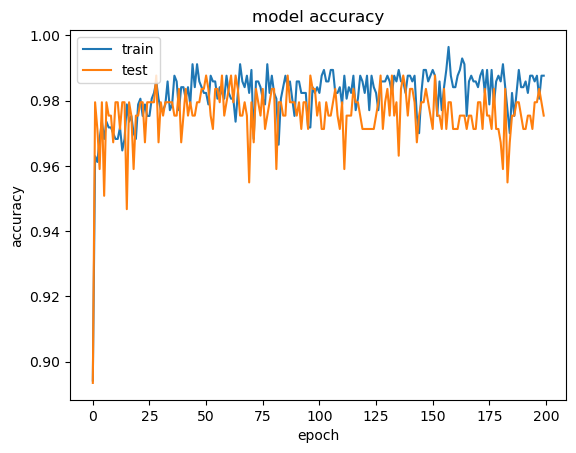

In [33]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
y_pred_probabilities = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probabilities > threshold).astype(int)
y_true= y_test

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

8/8 [==============================] - 0s 3ms/step
Accuracy:  0.975
Recall:  0.959
Precision:  0.992
ROC AUC:  0.975


In [40]:
np.shape(y_pred_probabilities)

(244, 1)

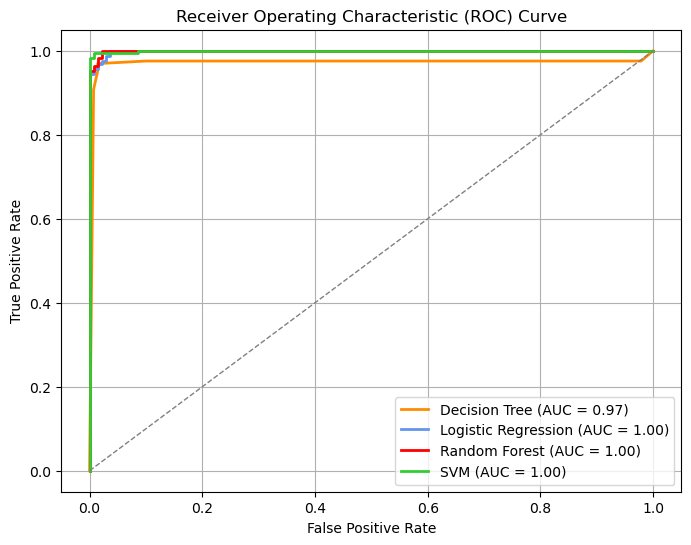

In [86]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_ct:.2f})')
plt.plot(fpr_lr, tpr_lr, color='cornflowerblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='limegreen', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
#plt.plot(fpr_lr, tpr_lr, color='cornflowerblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('all_ROC.jpg')
plt.show()

In [87]:
print('Decision Tree: ')
print('Accuracy: ',accuracy_ct)
print('Recall: ',recall_ct)
print('Precision: ',precision_ct)
print('ROC AUC: ',roc_auc_ct)

print('Logistic Regression')
print('Accuracy: ',accuracy_lr)
print('Recall: ',recall_lr)
print('Precision: ',precision_lr)
print('ROC AUC: ',roc_auc_lr)


print('Random Forest')
print('Accuracy: ',accuracy_rf)
print('Recall: ',recall_rf)
print('Precision: ',precision_rf)
print('ROC AUC: ',roc_auc_rf)

print('Support Vector Machine: ')
print('Accuracy: ',accuracy_svm)
print('Recall: ',recall_svm)
print('Precision: ',precision_svm)
print('ROC AUC: ',roc_auc_svm)


Decision Tree: 
Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.9714066608238388
Logistic Regression
Accuracy:  0.974
Recall:  0.963
Precision:  0.987
ROC AUC:  0.9988168273444348
Random Forest
Accuracy:  0.977
Recall:  0.969
Precision:  0.988
ROC AUC:  0.9992550394390886
Support Vector Machine: 
Accuracy:  0.99
Recall:  0.988
Precision:  0.994
ROC AUC:  0.9993865030674847


In [88]:
print('Decision Tree: ',accuracy_ct)
print('Logistic Regression',accuracy_lr)
print('Random Forest',accuracy_rf)
print('-->> Support Vector Machine: ',accuracy_svm)

Decision Tree:  0.977
Logistic Regression 0.974
Random Forest 0.977
-->> Support Vector Machine:  0.99


In [89]:
print('Decision Tree: ',recall_ct)
print('Logistic Regression',recall_lr)
print('Random Forest',recall_rf)
print('-->> Support Vector Machine: ',recall_svm)


Decision Tree:  0.969
Logistic Regression 0.963
Random Forest 0.969
-->> Support Vector Machine:  0.988


In [90]:
print('Decision Tree: ',precision_ct)
print('Logistic Regression',precision_lr)
print('Random Forest',precision_rf)
print('-->>    Support Vector Machine: ',precision_svm)


Decision Tree:  0.988
Logistic Regression 0.987
Random Forest 0.988
-->>    Support Vector Machine:  0.994


In [91]:
print('Decision Tree: ',roc_auc_ct)
print('Logistic Regression',roc_auc_lr)
print('Random Forest',roc_auc_rf)
print('-->> Support Vector Machine: ',roc_auc_svm)


Decision Tree:  0.9714066608238388
Logistic Regression 0.9988168273444348
Random Forest 0.9992550394390886
-->> Support Vector Machine:  0.9993865030674847
